<a href="https://colab.research.google.com/github/Park-hanna/Hanshin_Cat/blob/main/Hanta_Data%20fine-tuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 데이터 미세조정, 전이

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!mkdir /content/dataset

mkdir: cannot create directory ‘/content/dataset’: File exists


In [ ]:
!unzip -qq /content/drive/MyDrive/hanta_and_other_filtered3.zip -d /content/dataset

replace /content/dataset/test/hanta/hanta_451.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [ ]:
train_dir = '/content/dataset/train'
validation_dir = '/content/dataset/test'

In [ ]:
import matplotlib.pyplot as plt
import os
import tensorflow as tf

from tensorflow.keras.preprocessing import image_dataset_from_directory

In [ ]:
BATCH_SIZE = 32
IMG_SIZE = (160,160)

train_dataset = image_dataset_from_directory(train_dir,
                                             shuffle = True,
                                             batch_size = BATCH_SIZE,
                                             image_size = IMG_SIZE)

Found 899 files belonging to 2 classes.


In [ ]:
validation_dataset = image_dataset_from_directory(validation_dir,
                                                  shuffle = True,
                                                  batch_size = BATCH_SIZE,
                                                  image_size = IMG_SIZE)

Found 203 files belonging to 2 classes.


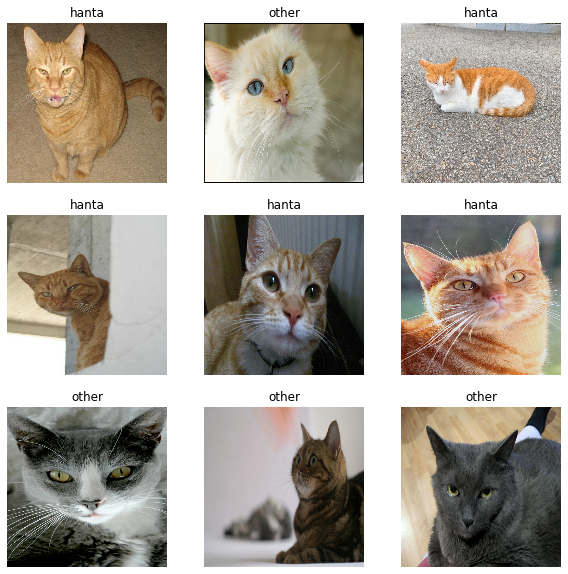

In [ ]:
class_names = train_dataset.class_names

plt.figure(figsize=(10,10))
for images, labels in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3,3,i+1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis('off')

In [ ]:
val_batches = tf.data.experimental.cardinality(validation_dataset)
test_dataset = validation_dataset.take(val_batches // 5)
validation_dataset = validation_dataset.skip(val_batches // 5)

In [ ]:
print('Number of Validation batches : %d' % tf.data.experimental.cardinality(validation_dataset))
print('Number of test batched : %d' % tf.data.experimental.cardinality(test_dataset))

Number of Validation batches : 6
Number of test batched : 1


In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size = AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size = AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size = AUTOTUNE)

In [ ]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
    tf.keras.layers.experimental.preprocessing.RandomRotation(0.2)
])

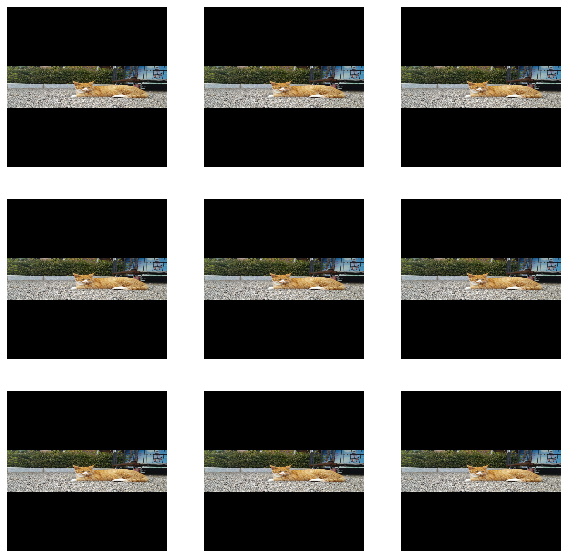

In [ ]:
for image, _ in train_dataset.take(1):
  plt.figure(figsize=(10,10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3,3,i+1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0]/ 255)
    plt.axis('off')

In [ ]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

In [ ]:
rescale = tf.keras.layers.experimental.preprocessing.Rescaling(1./127.5, offset = -1)

In [ ]:
IMG_SHAPE = IMG_SIZE + (3, )
base_model = tf.keras.applications.MobileNetV2(input_shape = IMG_SHAPE,
                                              include_top = False,
                                              weights = 'imagenet')

In [ ]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 5, 5, 1280)


In [ ]:
base_model.trainable = True

In [ ]:
base_model.summary()

Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 160, 160, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 80, 80, 32)   864         ['input_3[0][0]']                
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 80, 80, 32)   128         ['Conv1[0][0]']                  
                                                                                                  
 Conv1_relu (ReLU)              (None, 80, 80, 32)   0           ['bn_Conv1[0][

In [ ]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 1280)


In [ ]:
prediction_layer = tf.keras.layers.Dense(1)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 1)


In [ ]:
inputs = tf.keras.Input(shape=(160,160,3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training = False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [ ]:
base_learning_rate = 0.0001
model.compile(optimizer = tf.keras.optimizers.RMSprop(lr=base_learning_rate),
              loss = tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics = ['accuracy'])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


In [ ]:
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 sequential_1 (Sequential)   (None, 160, 160, 3)       0         
                                                                 
 tf.math.truediv_1 (TFOpLamb  (None, 160, 160, 3)      0         
 da)                                                             
                                                                 
 tf.math.subtract_1 (TFOpLam  (None, 160, 160, 3)      0         
 bda)                                                            
                                                                 
 mobilenetv2_1.00_160 (Funct  (None, 5, 5, 1280)       2257984   
 ional)                                                          
                                                           

In [ ]:
len(model.trainable_variables)

158

In [ ]:
initial_epochs = 10

loss0, accuracy0 = model.evaluate(validation_dataset)

6/6 [==============================] - 3s 276ms/step - loss: 0.7877 - accuracy: 0.4737


In [ ]:
history = model.fit(train_dataset,
                    epochs = initial_epochs,
                    validation_data = validation_dataset)

Epoch 1/10
29/29 [==============================] - 54s 2s/step - loss: 0.7424 - accuracy: 0.6040 - val_loss: 1.0778 - val_accuracy: 0.5205
Epoch 2/10
29/29 [==============================] - 47s 2s/step - loss: 0.4206 - accuracy: 0.8176 - val_loss: 0.6386 - val_accuracy: 0.7251
Epoch 3/10
29/29 [==============================] - 46s 2s/step - loss: 0.2937 - accuracy: 0.8788 - val_loss: 0.4286 - val_accuracy: 0.8596
Epoch 4/10
29/29 [==============================] - 46s 2s/step - loss: 0.2841 - accuracy: 0.8765 - val_loss: 0.2170 - val_accuracy: 0.9240
Epoch 5/10
29/29 [==============================] - 46s 2s/step - loss: 0.2163 - accuracy: 0.9110 - val_loss: 0.1813 - val_accuracy: 0.9240
Epoch 6/10
29/29 [==============================] - 46s 2s/step - loss: 0.2116 - accuracy: 0.9166 - val_loss: 0.2968 - val_accuracy: 0.8772
Epoch 7/10
29/29 [==============================] - 46s 2s/step - loss: 0.1785 - accuracy: 0.9277 - val_loss: 0.3985 - val_accuracy: 0.8304
Epoch 8/10
29/29 [==

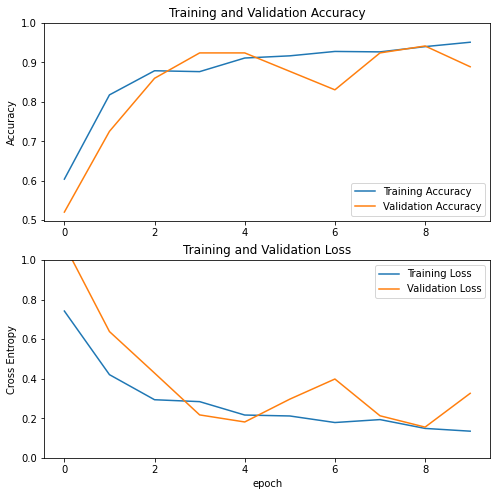

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8,8))
plt.subplot(2,1,1)
plt.plot(acc, label = 'Training Accuracy')
plt.plot(val_acc , label = "Validation Accuracy")
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title("Training and Validation Accuracy")

plt.subplot(2,1,2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0, 1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [ ]:
base_model.trainable = True

In [ ]:
print('initial loss : {:.2f}'.format(loss0))
print('initial accuracy : {:.2f}'.format(accuracy0))

initial loss : 0.79
initial accuracy : 0.47


In [ ]:
print('Number of layers in the base model : ', len(base_model.layers))

fine_tune_at = 100

for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

Number of layers in the base model :  154


In [ ]:
model.compile(loss = tf.keras.losses.BinaryCrossentropy(from_logits = True),
              optimizer = tf.keras.optimizers.RMSprop(lr=base_learning_rate/10),
              metrics = ['accuracy'])

In [ ]:
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 sequential_1 (Sequential)   (None, 160, 160, 3)       0         
                                                                 
 tf.math.truediv_1 (TFOpLamb  (None, 160, 160, 3)      0         
 da)                                                             
                                                                 
 tf.math.subtract_1 (TFOpLam  (None, 160, 160, 3)      0         
 bda)                                                            
                                                                 
 mobilenetv2_1.00_160 (Funct  (None, 5, 5, 1280)       2257984   
 ional)                                                          
                                                           

In [ ]:
len(model.trainable_variables)

56

In [ ]:
fine_tune_epochs = 10
total_epochs = initial_epochs + fine_tune_epochs

history_fine = model.fit(train_dataset,
                         epochs = total_epochs,
                         initial_epoch = history.epoch[-1],
                         validation_data = validation_dataset)

Epoch 10/20
29/29 [==============================] - 27s 749ms/step - loss: 0.0602 - accuracy: 0.9778 - val_loss: 0.2595 - val_accuracy: 0.9064
Epoch 11/20
29/29 [==============================] - 23s 760ms/step - loss: 0.0516 - accuracy: 0.9778 - val_loss: 0.2495 - val_accuracy: 0.9298
Epoch 12/20
29/29 [==============================] - 23s 764ms/step - loss: 0.0389 - accuracy: 0.9867 - val_loss: 0.2108 - val_accuracy: 0.9240
Epoch 13/20
29/29 [==============================] - 23s 765ms/step - loss: 0.0370 - accuracy: 0.9833 - val_loss: 0.2382 - val_accuracy: 0.9123
Epoch 14/20
29/29 [==============================] - 22s 746ms/step - loss: 0.0280 - accuracy: 0.9911 - val_loss: 0.2853 - val_accuracy: 0.9123
Epoch 15/20
29/29 [==============================] - 23s 768ms/step - loss: 0.0325 - accuracy: 0.9833 - val_loss: 0.2650 - val_accuracy: 0.9298
Epoch 16/20
29/29 [==============================] - 23s 777ms/step - loss: 0.0306 - accuracy: 0.9889 - val_loss: 0.2778 - val_accuracy:

In [ ]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

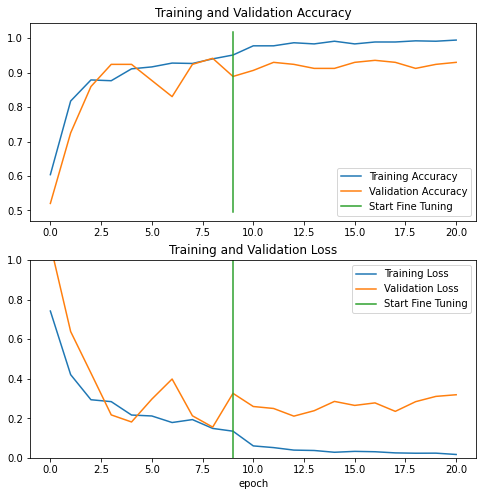

In [ ]:
plt.figure(figsize=(8,8))
plt.subplot(2,1,1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
#plt.ylim([0.8, 1])
plt.plot([initial_epochs-1, initial_epochs-1],
         plt.ylim(), label="Start Fine Tuning")
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2,1,2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1, initial_epochs-1],
         plt.ylim(), label="Start Fine Tuning")
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [ ]:
loss, accuracy = model.evaluate(test_dataset)
print('Test accuracy :', accuracy)

1/1 [==============================] - 1s 657ms/step - loss: 0.1999 - accuracy: 0.9062
Test accuracy : 0.90625


Predictions:
 [1 1 0 1 0 0 0 0 0 0 1 1 0 1 0 1 0 1 1 0 0 1 1 1 1 1 0 1 1 1 1 1]
Labels:
 [1 1 0 1 0 0 0 0 0 0 1 1 0 1 0 1 0 1 0 0 0 1 1 1 1 1 0 1 1 1 1 1]


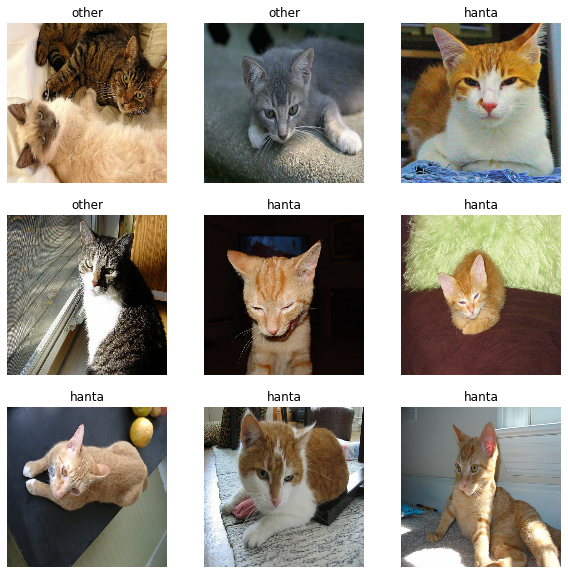

In [ ]:
image_batch, label_batch = test_dataset.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch).flatten()

predictions = tf.nn.sigmoid(predictions)
predictions = tf.where(predictions < 0.5 ,0, 1)

print('Predictions:\n', predictions.numpy())
print('Labels:\n', label_batch)

plt.figure(figsize=(10,10))
for i in range(9):
  ax = plt.subplot(3,3,i+1)
  plt.imshow(image_batch[i].astype("uint8"))
  plt.title(class_names[predictions[i]])
  plt.axis('off')